In [9]:
import numpy as np
import matplotlib.pyplot as plt 
import rasterio
%matplotlib inline

In [10]:
im_file = "../data/satelite/LC08_L1TP_194027_20160825_20170322_01_T1_B10.TIF"
#im_tif = plt.imread(im_file)
im_r = rasterio.open(im_file)
im_tif = im_r.read_band(1)

/home/david/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: read_band() is deprecated and will be removed by Rasterio 1.0. Please use read() instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
from pyproj import Proj, transform

A = im_r.affine
Ainv = ~A

def latlong_to_image_coords(lat, lng):    
    inProj = Proj(init='epsg:4326')
    outProj = Proj(init='epsg:32632')
    x, y = transform(inProj, outProj, lng, lat)
    imX, imY = Ainv * (x, y)
    return imX, imY

In [12]:
def get_absolute_intensity(x, y):
    return im_tif[int(x), int(y)]

def get_relative_intensity(x, y, delta=10):
    return get_absolute_intensity(x, y) / im_tif[int(x)-delta:int(x)+delta, int(y)-delta:int(y)+delta].mean()

In [13]:
lookup_coord = [47.366193, 8.541418]
x, y = latlong_to_image_coords(lookup_coord[0], lookup_coord[1])
print(x)
print(y)

1442.9996403606565
4255.131325068098


(7921, 7821)


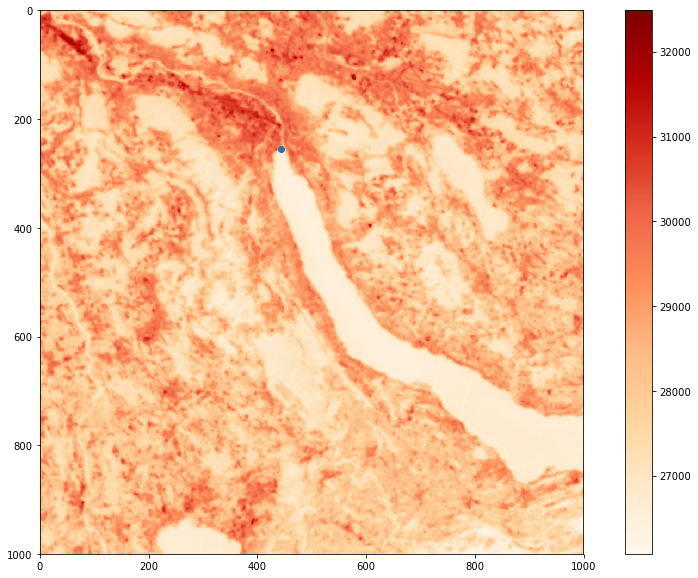

In [14]:
plt.figure(figsize=(15,10))
plt.imshow(im_tif[4000:5000, 1000:2000], cmap="OrRd")
plt.colorbar()
plt.scatter([x-1000], [y-4000])
print(im_tif.shape)

In [7]:
get_absolute_intensity(x, y)

28324

In [8]:
get_relative_intensity(x, y)

1.0227066032800884

## Filter Buildings

In [16]:
import geojson

with open("../data/buildings_switzerland.json") as f:
    buildings = geojson.load(f)

In [17]:
old_list = buildings["features"]
new_list = []

min_lat = 47.341948
max_lat = 47.396384
min_lng = 8.469858
max_lng = 8.563266

i = 0
while len(old_list) > 0:
    i += 1
    entry = old_list.pop()
    coords = entry["geometry"]["coordinates"][0]
    valid = True
    for c in coords:
        try:
            x, y = c
            if x < min_lng or x > max_lng or y < min_lat or y > max_lat:
                valid = False
        except:
            valid = False
    if valid:
        entry["geometry"]["coordinates"][0] = coords
        new_list.append(entry)
    

In [18]:
buildings["features"] = new_list

In [19]:
buildings["features"][1]["geometry"]["coordinates"][0]

[[8.525565, 47.3477233],
 [8.5256553, 47.3477751],
 [8.5259048, 47.3475752],
 [8.5258144, 47.3475234],
 [8.525565, 47.3477233]]

In [20]:
len(new_list)

25146

## Create relative intensity as score

In [21]:
import math

def segments(poly):
        """A sequence of (x,y) numeric coordinates pairs """
        return zip(poly, poly[1:] + [poly[0]])

def area(poly):
    """A sequence of (x,y) numeric coordinates pairs """
    return 0.5 * abs(sum(x0*y1 - x1*y0
        for ((x0, y0), (x1, y1)) in segments(poly)))

def perimeter(poly):
    """A sequence of (x,y) numeric coordinates pairs """
    return abs(sum(math.hypot(x0-x1,y0-y1) for ((x0, y0), (x1, y1)) in segments(poly)))


In [22]:
poly = buildings["features"][5]["geometry"]["coordinates"][0]
per = perimeter(poly)
circle_area = per**2 / 4 / math.pi
print(area(poly) / circle_area)

0.7107857676123582


In [23]:
for i in range(len(buildings["features"])):
    coords = buildings["features"][i]["geometry"]["coordinates"][0]
    
    X = []
    Y = []
    for x, y in coords:
        X.append(x)
        Y.append(y)
    x_center = sum(X) / len(X)
    y_center = sum(Y) / len(Y)

    im_x, im_y = latlong_to_image_coords(y_center, x_center)
    
    relative_intensity = get_relative_intensity(im_x, im_y)
    
    per = perimeter(coords)
    circle_area = per**2 / 4 / math.pi
    compactness = area(coords) / circle_area
    
    buildings["features"][i]["properties"]["relative_intensity"] = relative_intensity
    buildings["features"][i]["properties"]["compactness"] = compactness
    buildings["features"][i]["properties"]["score"] = relative_intensity+0.05*(1-compactness)

In [ ]:
with open("data/buildings_switzerland_final.json", "w") as f:
    geojson.dump(buildings, f)

In [24]:
scores = []

for i in range(len(buildings["features"])):
    scores.append(buildings["features"][i]["properties"]["score"])

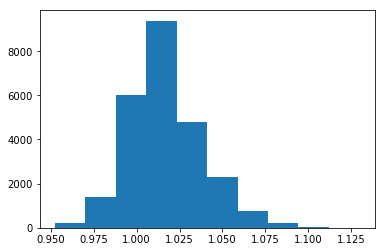

In [25]:
plt.hist(np.array(scores))
plt.show()


## Exploring night-time images

In [27]:
im_file_night = "../data/satelite/LC08_L1GT_054217_20150717_20170407_01_T2_B9.TIF"
im_r_night = rasterio.open(im_file_night)
im_tif_night = im_r_night.read_band(1)

/home/david/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: read_band() is deprecated and will be removed by Rasterio 1.0. Please use read() instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


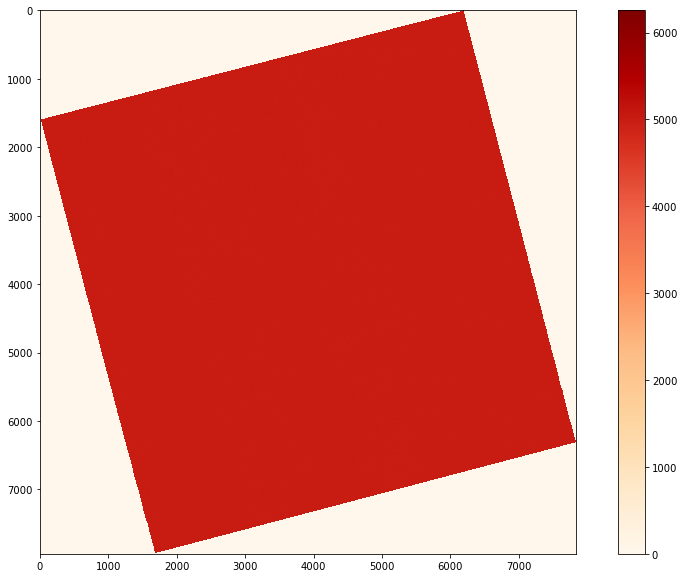

In [28]:
plt.figure(figsize=(15,10))
plt.imshow(im_tif_night, cmap="OrRd")
plt.colorbar()
plt.show()

In [29]:
im_tif_night.min()

0

In [30]:
im_tif_night.max()

6257

In [31]:
np.median(im_tif_night)

4994.0

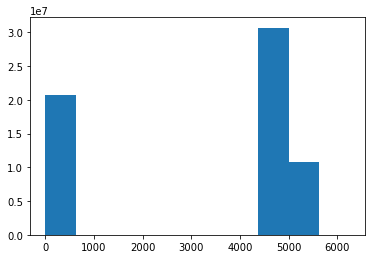

In [32]:
plt.hist(im_tif_night.flat)
plt.show()